In [3]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import os, json
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")
from nnn.uv import *

Define the inputs: sample sheet and data directory below

In [4]:
sample_sheet_file = './data/uv_melt/ECLSampleSheet230106.csv'
datadir="./data/uv_melt/ECLExport/230105_SL001_eCuvette_troubleshoot/"

Define the output filenames:

In [13]:
result_file='./data/uv_melt/uvmelt_230105.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_220105.csv'

Run curve fitting with manual blanking:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.20it/s]


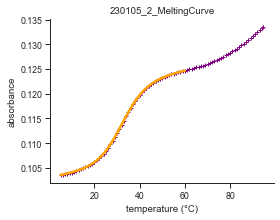

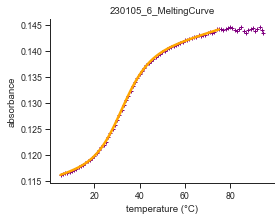

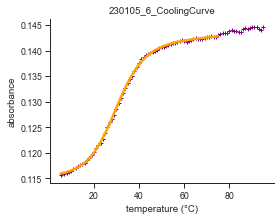

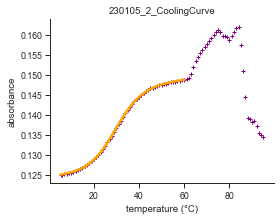

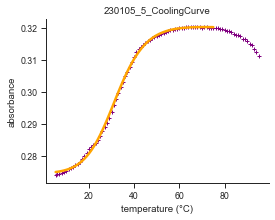

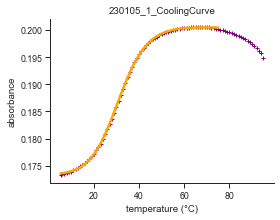

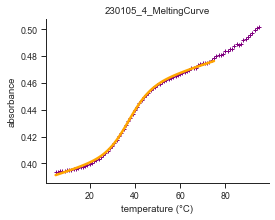

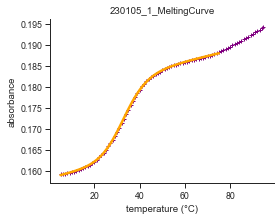

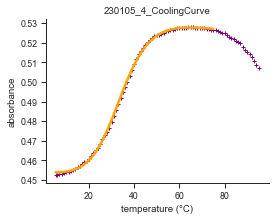

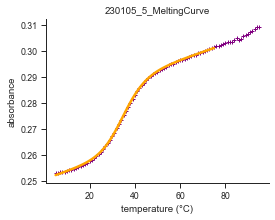

In [20]:
result_df = fit_all_manual_blank(datadir, sample_sheet_file, result_file=result_file)

In [9]:
# Or read from disk
result_df = pd.read_csv(result_file, index_col=0).query('pass_qc')

Let's plot the curves that did not pass QC:

In [11]:
df = result_df.query('~pass_qc')
for i,row in df.iterrows():
    plot_curve_fit_result(row)

Now aggregate the results in the sample (different melt and cooling curves):

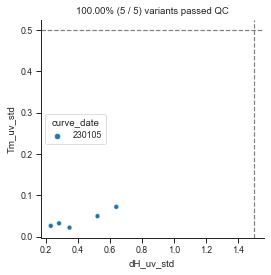

In [14]:
result_agg_df = agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               sample_sheet_file=sample_sheet_file, clean=True)

In [15]:
result_df.columns

Index(['curve_date', 'curve_num', 'curve_name', 'dH', 'dH_std', 'Tm', 'Tm_std',
       'fmax', 'fmax_std', 'fmin', 'fmin_std', 'slope', 'slope_std', 'rmse',
       'celsius_min', 'celsius_max', 'data_file', 'blank', 'pass_qc', 'SEQID',
       'conc_uM', 'Na_mM', 'dG_37', 'dS'],
      dtype='object')

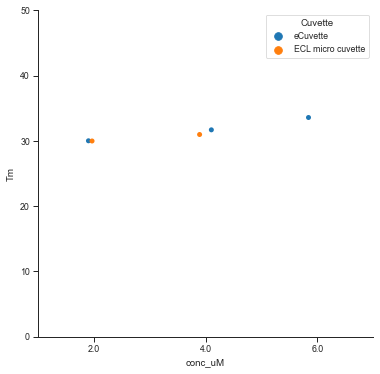

In [39]:
fig, ax = plt.subplots(figsize=(6,6))
sns.stripplot(data=result_df.query('pass_qc & curve_name == "CoolingCurve"'), x='conc_uM', y='Tm',hue='Cuvette', palette='tab10')
plt.ylim([0, 50])
sns.despine()

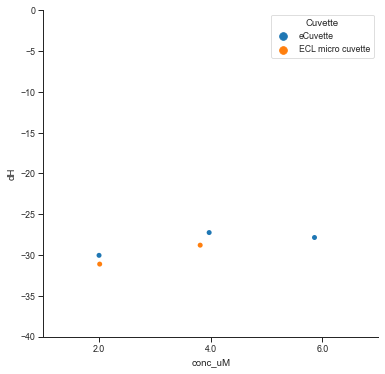

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
sns.stripplot(data=result_df.query('pass_qc & curve_name == "CoolingCurve"'), x='conc_uM', y='dH',hue='Cuvette', palette='tab10')
plt.ylim([-40, 0])
sns.despine()

In [24]:
arr = pd.read_csv('./data/models/raw/arr.csv', index_col=0)

df = result_agg_df.merge(arr, how='left', on='SEQID')

In [31]:
df_q.sort_values(by='curve_num')[['RefSeq','Tm_uv','Tm']]

,RefSeq,Tm_uv,Tm
11,CGATTCGGAAACGAGTCG,47.513484,41.471961
13,CGTGTCGGAAACGATACG,50.613563,43.863119
15,CGTCCCGGAAACGGCACG,54.988827,30.517163
3,CGGCTCGGAAACGACCCG,53.567695,33.523030
5,CGGCGCGGAAACGCCCCG,69.770065,42.600818
7,CGCTACGGAAACGTTGCG,51.975455,46.909011
9,CGCTTCGGAAACGAGGCG,54.674199,46.506094


In [32]:
util.get_mfe_struct('CGTCCCGGAAACGGCACG', celsius=30, sodium=.1)

'(((.(((....))).)))'

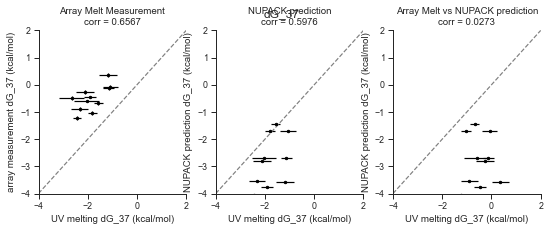

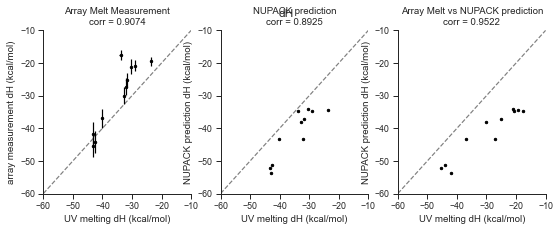

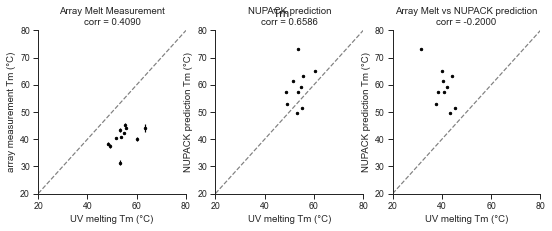

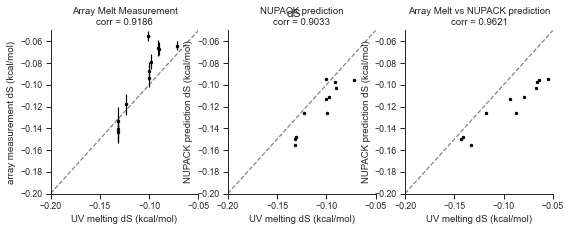

In [43]:
series = 'WC'
# plot_query = 'Na_mM == 25 & is_hairpin & (Series == "TETRAloop" or Series == "TRIloop")'
plot_query = 'Na_mM == 25 & is_hairpin & (Series == "WatsonCrick")'
df_q = df.query(plot_query)

def plot_uv_comparison(df_q, param, lim, array_suffix=''):
    unit_dict = dict(dH='kcal/mol', dS='kcal/mol', dG_37='kcal/mol', Tm='°C')
    unit = unit_dict[param]
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    ax[0].plot(lim, lim, '--', c='gray')
    ax[0].errorbar(df_q[param + '_uv'], df_q[param+array_suffix],
                   xerr=df_q[param+'_uv_std'], yerr=df_q[param+'_se'],
                   fmt='k.')
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)
    ax[0].set_xlabel(f'UV melting {param} ({unit})')
    ax[0].set_ylabel(f'array measurement {param} ({unit})')
    ax[0].set_title('Array Melt Measurement\ncorr = %.4f' %
                    pearsonr(df_q[param + '_uv'], df_q[param+array_suffix])[0])

    ax[1].errorbar(df_q[param+'_uv'], df_q[param+'_NUPACK_salt_corrected'],
                   xerr=df_q[param+'_uv_std'],
                   fmt='k.')
    ax[1].plot(lim, lim, '--', c='gray')
    ax[1].set_xlim(lim)
    ax[1].set_ylim(lim)
    ax[1].set_xlabel(f'UV melting {param} ({unit})')
    ax[1].set_ylabel(f'NUPACK prediction {param} ({unit})')
    ax[1].set_title('NUPACK prediction\ncorr = %.4f' %
                    pearsonr(df_q[param+'_uv'], df_q[param+'_NUPACK_salt_corrected'])[0])

    x = df_q[param+array_suffix]
    y = df_q[param+'_NUPACK_salt_corrected']
    ax[2].errorbar(x, y,
               xerr=df_q[param+'_uv_std'],
               fmt='k.')
    ax[2].plot(lim, lim, '--', c='gray')
    ax[2].set_xlim(lim)
    ax[2].set_ylim(lim)
    ax[2].set_xlabel(f'UV melting {param} ({unit})')
    ax[2].set_ylabel(f'NUPACK prediction {param} ({unit})')
    ax[2].set_title('Array Melt vs NUPACK prediction\ncorr = %.4f' %
                    pearsonr(x, y)[0])
    
    plt.suptitle(param)
    sns.despine()
    # plt.show()
    
plot_uv_comparison(df_q, 'dG_37', lim = (-4, 2))
util.save_fig(f'./fig/UV_melt/{series}_dG_37.pdf')
plot_uv_comparison(df_q, 'dH', lim = (-60, -10))
util.save_fig(f'./fig/UV_melt/{series}_dH.pdf')
plot_uv_comparison(df_q, 'Tm', lim = (20, 80))
util.save_fig(f'./fig/UV_melt/{series}_Tm.pdf')
plot_uv_comparison(df_q, 'dS', lim = (-.2, -.05))
util.save_fig(f'./fig/UV_melt/{series}_dS.pdf')

In [413]:
plot_query = 'Na_mM == 25 & is_hairpin'
df_q = df.query(plot_query)

ols_Tm = fit_param_offset(df_q, 'Tm', fix_slope=True, adjusted=False)
ols_dG_37 = fit_param_offset(df_q, 'dG_37', fix_slope=True, adjusted=False)
ols_dH = fit_param_offset(df_q, 'dH', fix_slope=True, adjusted=False)
ols_dS = fit_param_offset(df_q, 'dS', fix_slope=True, adjusted=False)
print(ols_Tm.coef_, ols_dG_37.coef_, ols_dH.coef_, ols_dS.coef_)
correction = dict(Tm=ols_Tm.coef_, dG_37=ols_dG_37.coef_)

fileio.write_pickle(correction, './data/uv_melt/correction.pkl')

[ 1.        12.6771236] [ 1.         -1.13626671] [1.         2.74880351] [1.         0.01283626]


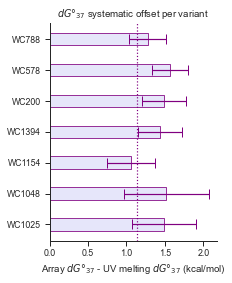

In [405]:
# correction = fileio.read_pickle('./data/uv_melt/correction.pkl')

plot_query = 'Na_mM == 25 & is_hairpin & (Series == "WatsonCrick")'
df_q = df.query(plot_query)

plt.figure(figsize=(3, 4))
plt.barh(df_q['SEQID'], df_q['dG_37'] - df_q['dG_37_uv'], 
        xerr=df_q['dG_37_se'] + df_q['dG_37_uv_std'],
        fc='lavender', height=0.4, edgecolor='purple', ecolor='purple', capsize=5)
plt.axvline(x=-correction['dG_37'][1], c='purple', linestyle=':')
plt.xlabel(r'Array $dG°_{37}$ - UV melting $dG°_{37}$ (kcal/mol)')
plt.title(r'$dG°_{37}$ systematic offset per variant')
sns.despine()
util.save_fig('./fig/UV_melt/dG_37_offset_per_variant_new.pdf')

In [418]:
p = 'Tm'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['dG_37_corrected'] = util.get_dG(dH=arr.dH, Tm=arr.Tm_corrected, celsius=37)

plotting.plot_colored_scatter_comparison(data=arr, x='dG_37', y='dG_37_corrected', lim=(-7, 3))

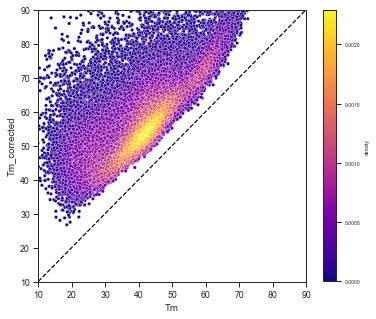

In [442]:
p = 'dG_37'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['Tm_corrected'] = (C2T + 37) / (1 - arr.dG_37_corrected / arr.dH) - C2T

plotting.plot_colored_scatter_comparison(data=arr, x='Tm', y='Tm_corrected', lim=(10, 90))

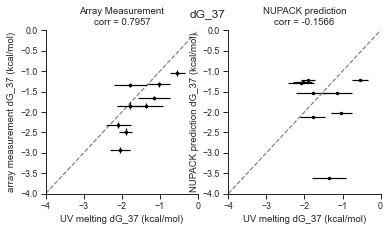

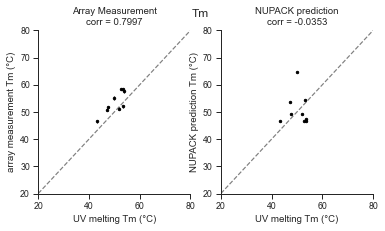

In [439]:
# Only correct Tm
arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
p = 'Tm'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['dG_37_corrected'] = util.get_dG(dH=arr.dH, Tm=arr.Tm_corrected, celsius=37)
df = result_agg_df.merge(arr, how='left', on='SEQID')

plot_query = 'Na_mM == 25 & is_hairpin & dG_37_uv_std < 0.5  & (Series != "WatsonCrick")'
# plot_query = 'Na_mM == 25 & is_hairpin & dG_37_uv_std < 0.5'
df_q = df.query(plot_query)

plot_uv_comparison(df_q, 'dG_37', lim = (-4, -0), array_suffix='_corrected')
plot_uv_comparison(df_q, 'Tm', lim = (20, 80), array_suffix='_corrected')

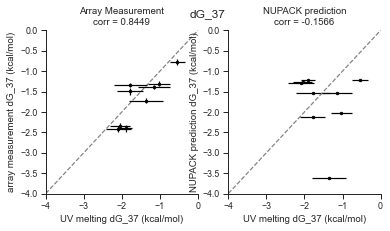

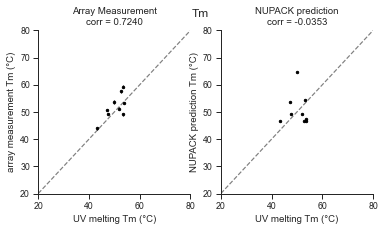

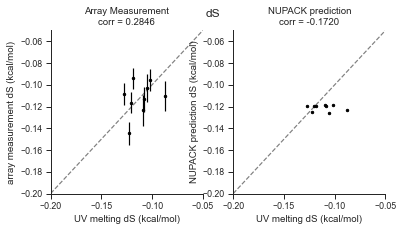

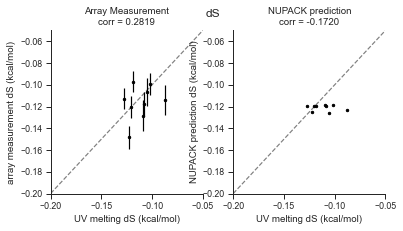

In [448]:
# Only correct dG_37
arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
p = 'dG_37'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['Tm_corrected'] = (C2T + 37) / (1 - arr.dG_37_corrected / arr.dH) - C2T
arr['dS_corrected'] = arr.dH / (arr.Tm_corrected + C2T)
df = result_agg_df.merge(arr, how='left', on='SEQID')
plot_query = 'Na_mM == 25 & is_hairpin & dG_37_uv_std < 0.5  & (Series != "WatsonCrick")'
# plot_query = 'Na_mM == 25 & is_hairpin & dG_37_uv_std < 0.5'
df_q = df.query(plot_query)

plot_uv_comparison(df_q, 'dG_37', lim = (-4, -0), array_suffix='_corrected')
plot_uv_comparison(df_q, 'Tm', lim = (20, 80), array_suffix='_corrected')
plot_uv_comparison(df_q, 'dS', lim = (-.2, -.05), array_suffix='_corrected')
plot_uv_comparison(df_q, 'dS', lim = (-.2, -.05))

Correcting dG_37 only makes more sense to me. Let's apply the correction and save to file, both with col name suffix and overwriting the uncorrected values in place.

In [449]:
arr = pd.read_csv('./data/models/raw/arr.csv', index_col=0)
p = 'dG_37'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['Tm_corrected'] = (C2T + 37) / (1 - arr.dG_37_corrected / arr.dH) - C2T
arr['dS_corrected'] = arr.dH / (arr.Tm_corrected + C2T)

arr.to_csv('./data/models/raw/arr_corrected.csv')

In [450]:
arr = pd.read_csv('./data/models/raw/arr.csv', index_col=0)
p = 'dG_37'
arr[p] = correct_param(arr, correction, p)
arr['Tm'] = (C2T + 37) / (1 - arr.dG_37 / arr.dH) - C2T
arr['dS'] = arr.dH / (arr.Tm + C2T)

arr.to_csv('./data/models/raw/arr_corrected_inplace.csv')

In [451]:
arr = pd.read_csv('./data/models/raw/arr_corrected_inplace.csv', index_col=0)

## Append data availability to ECLComplexes table

In [43]:
agg_result_file='./data/uv_melt/uvmelt_agg_221121.csv'
agg_result = pd.read_csv(agg_result_file, index_col=0)

In [51]:
available_seqid = np.unique(agg_result.query('Na_mM == 25').SEQID).tolist()

In [61]:
agg_result

,SEQID,curve_date,curve_num,dH_uv,dH_uv_std,Tm_uv,Tm_uv_std,dG_37_uv,dG_37_uv_std,dS_uv,dS_uv_std,is_hairpin,Na_mM,conc_uM,purification
0,BNNN2110,221111,3,-35.447495,0.327489,50.782953,0.039606,-1.508248,0.453413,-0.109428,0.001011,True,25,9.0,standard desalting
1,BNNN3096,221111,4,-45.065628,1.115309,51.323423,0.094843,-1.989359,1.542916,-0.138889,0.003438,True,25,9.0,standard desalting
3,BNNN8973,221111,6,-37.811548,0.217965,60.552473,0.037681,-2.668711,0.297596,-0.113309,0.000653,True,25,9.0,standard desalting
5,MMCNN112,221115,4,-36.144861,0.196944,53.567695,0.026585,-1.832888,0.271565,-0.110630,0.000603,True,25,9.0,standard desalting
6,MMCNN112,221117,4,-40.660049,0.465793,64.046859,0.092523,-3.261379,0.632947,-0.120583,0.001382,True,1000,10.0,standard desalting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,WC68,220727,5,-39.585300,0.851525,69.964030,0.096512,-3.803083,1.147894,-0.115371,0.002482,True,1000,8.0,standard desalting
73,WC68,220727,6,-36.898640,0.544520,69.503385,0.068905,-3.500128,0.734483,-0.107685,0.001589,True,1000,10.0,standard desalting
74,WC68,220727,7,-38.229045,0.791751,69.552330,0.093010,-3.631269,1.067893,-0.111552,0.002311,True,1000,12.0,standard desalting
75,WC788,220828,7,-47.200605,0.210114,58.200286,0.024790,-3.019965,0.287816,-0.142449,0.000634,True,50,6.4,standard desalting


In [65]:
ecl_complexes_df = pd.read_csv('./data/uv_melt/ECLTables/ECLComplexes_230117.csv')

ecl_complexes_df['DataAvailable'] = ecl_complexes_df.PLEXID.apply(lambda x: x in available_seqid or x.split('_')[0] in available_seqid)

ecl_complexes_df.DataAvailable.sum()

38

In [66]:
ecl_complexes_df.to_csv('./data/uv_melt/ECLTables/ECLComplexes_230117.csv')